## Estimating DFF with the option to downsample the input signal before calculating baseline

In [200]:
def dff(data, window, percentile, downsample=1):
    """
    Estimate delta-f / f_baseline with the option to downsample
    
    data : 1D numpy array
        Data to be processed
        
    window : int
        Window size for baseline estimation. If downsampling is used, window will shrink proportionally
        
    percentile : int
        Percentile used as baseline
    
    downsample : int
        Rate of downsampling used before estimating baseline. For no downsampling, use downsample=1.
    """
    
    from scipy.signal import decimate
    from scipy.ndimage.filters import percentile_filter
    from numpy import interp
    
    if downsample == 1:
        baseline = percentile_filter(data, percentile=percentile, size=window)
    else:
        data_ds = decimate(data, downsample, ftype='iir', zero_phase=True)
        # using decimate with the default filter shifts the outputby ~1-2% relative to the input. 
        # Correct for baseline shift by adding a small constant to data_ds
        data_ds += data.min() - data_ds.min()
        baseline_ds = percentile_filter(data_ds, percentile=percentile, size=window//downsample)
        
        baseline = interp(range(0, len(data)), range(0, len(data), downsample), baseline_ds)
    
    return (data - baseline) / baseline

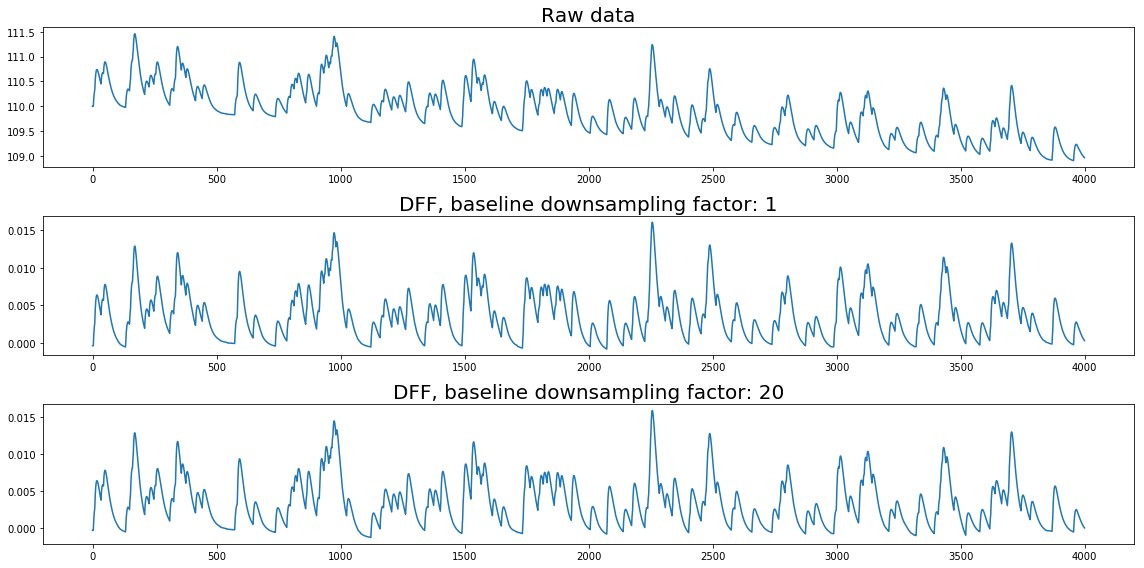

In [218]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# make some fake data by convolving "spikes" with a "calcum kernel"
spike_data = np.random.randint(0, 30, 4000) == 0
calcium_data = (10 + np.convolve(spike_data, kern, mode='same')) * np.exp(.00003 * -np.arange(len(spike_data))) + 100

# sliding baseline estimation parameters
window = 600
perc = 10

fig, axs = plt.subplots(nrows=3, figsize=(16,8))
axs[0].plot(calcium_data)
axs[0].title.set_text('Raw data')
axs[0].title.set_fontsize(20)

tmp_raw = dff(calcium_data, window, perc, 1)
axs[1].plot(tmp_raw)
axs[1].title.set_text('DFF, baseline downsampling factor: {0}'.format(1))
axs[1].title.set_fontsize(20)

tmp_ds = dff(calcium_data, window, perc, 20)
axs[2].plot(tmp_ds)
axs[2].title.set_text('DFF, baseline downsampling factor: {0}'.format(20))
axs[2].title.set_fontsize(20)
plt.tight_layout()